# Tiktok

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import re
from difflib import SequenceMatcher

In [ ]:
tt_june = (
    pd.read_csv('DATA/tiktokjune2022.csv')
    .assign(Month='June')
    .rename(columns={
        "Tiktoker": "username",
        "influencer name":"name",
        "Subscribers count": "subs",
        "Views avg.": "views",
        "Likes avg": "likes",
        "Comments avg.": "comments",
        "Shares avg": "shares",
        "Month": "month"
    })
)
tt_june.head(1)

In [ ]:
tt_sep = (
    pd.read_csv('DATA/Tiktoksep2022.csv')
    .assign(Month='September')
    .rename(columns={
        "Tiktoker name": "name",
        "Tiktok name":"username",
        "Subscribers": "subs",
        "Views avg.": "views",
        "Likes avg.": "likes",
        "Comments avg.": "comments",
        "Shares avg.": "shares",
        "Month": "month"
    })
    .drop("S.no", axis=1)
)
tt_sep.head(1)

In [ ]:
tt_nov = (
    pd.read_csv('DATA/tiktoknov2022.csv')
    .assign(Month='November')
    .rename(columns={
        "Tiktoker name": "name",
        "Tiktok name":"username",
        "\nFollowers": "subs",
        "Views (Avg.)": "views",
        "Likes (Avg.)": "likes",
        "Comments (Avg.)": "comments",
        "Shares (Avg.)": "shares",
        "Month": "month"
    })
    .drop("row-cell", axis=1)
    .drop(0)
)
tt_nov.head(1)

In [ ]:
tt_dec = (
    pd.read_csv('DATA/TIKTOKDEC2022.csv')
    .assign(Month='December')
    .rename(columns={
        "Tiktoker name": "name",
        "Tiktok name":"username",
        "followers": "subs",
        "views(avg)": "views",
        "likes(avg.)": "likes",
        "comments(avg.)": "comments",
        "shares(avg.)": "shares",
        "Month": "month"
    })
    .drop("Rank", axis=1)
)
tt_dec.head(1)

In [ ]:
def cientific_int(column: pd.Series) -> pd.Series:
    return (
        column
        .fillna('0')
        .replace({'K': '*1e3', 'M': '*1e6', 'G':'*1e9'}, regex=True)
        .map(pd.eval)
        .astype(int)
        .replace(0, np.nan)
    )


numeric_text_cols = ['subs', 'views', 'likes', 'comments', 'shares']

tt_june.loc[:, numeric_text_cols] = tt_june[numeric_text_cols].apply(cientific_int)
tt_sep.loc[:, numeric_text_cols] = tt_sep[numeric_text_cols].apply(cientific_int)
tt_nov.loc[:, numeric_text_cols] = tt_nov[numeric_text_cols].apply(cientific_int)
tt_dec.loc[:, numeric_text_cols] = tt_dec[numeric_text_cols].apply(cientific_int)

In [ ]:
tt_months = (
    pd.concat([tt_june, tt_sep, tt_nov, tt_dec], ignore_index=True)
    .drop_duplicates()
)

tt_months.head(3)

# Análisis

## 1. Tenemos 3055 cuentas únicas en nuestros registros de tiktok


In [ ]:
tt_months.username.drop_duplicates().size

## 2. Medias de followers, views, likes, comments y shares de cada cuenta

In [ ]:
tt_means = (
    tt_months
    .groupby('username')
     # aggregate functiosn skips nan by deffault
    .aggregate({
        'subs': 'mean',
        'views': 'mean',
        'likes': 'mean',
        'comments': 'mean',
        'shares': 'mean'
    })    
    .reset_index()
    .sort_values('subs', ascending=False)
)

In [ ]:
tt_means

## 3. Métricas de valor

In [ ]:
tt_means['views_ratio'] = tt_means.views / tt_means.subs
tt_means['likes_ratio'] = tt_means.likes / tt_means.subs
tt_means['comments_ratio'] = tt_means.comments / tt_means.subs
tt_means['share_ratio'] = tt_means.shares / tt_means.subs

In [ ]:
tt_means

## 4. Gráficas del numero de cuentas que inicien por cada letra del alfabeto y agrupar en una categoría todos los que no comiencen con una letra del alfabeto

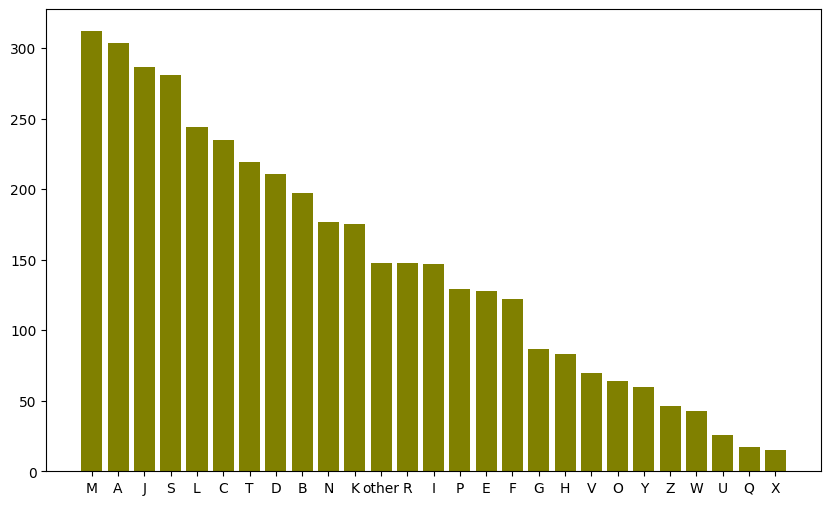

In [ ]:
def get_inicial(name: str) -> str:
    name = str(name)
    first_is_letter = re.search(r'^[a-zA-Z]', name)
    if first_is_letter:
        return name[0].upper()
    else:
        return 'other'


initials = (
    tt_months.name
    .map(get_inicial)
    .value_counts()
    .reset_index(name='frequency')
    .rename(columns={
        'index': 'letter',
        'name': 'letter'
    })
)
plt.figure(figsize=(10, 6)) 
plt.bar(initials.letter, initials.frequency, color = 'olive')
plt.show()

## 5. ¿Cual es la cuenta de tiktok con mas caracteres en su nombre?

In [ ]:
name_len = (
    tt_months[['name', 'username']]
    .assign(len_name = tt_months.name.map(lambda x: len(str(x))))
    .assign(len_username = tt_months.username.map(lambda x: len(str(x))))
)
tds1 = name_len.loc[name_len.len_name.idxmax()]
tds2 = name_len.loc[name_len.len_username.idxmax()]

In [ ]:
tds2

In [ ]:
tds1

## 6. Cuántas cuentas de tiktok tienen el nombre del aguno de estos animales: perro, gato, leon tigre?

In [ ]:
(tt_months.username.str.contains(r'^(perro|gato|leon|tigre)$') | tt_months.username.str.contains(r'^(perro|gato|leon|tigre)$')).sum()

<<<<<<< local <removed>


/tmp/ipykernel_9500/3064001155.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (tt_months.username.str.contains(r'^(perro|gato|leon|tigre)$') | tt_months.username.str.contains(r'^(perro|gato|leon|tigre)$')).sum()


>>>>>>> remote <modified: >


## 7. Defina una metrica que identifique las 10 cuentas más importantes de tiktok

In [ ]:
tt_means = (
    tt_means
    .assign(
        engagement_size = (tt_means.views / tt_means.subs) * (tt_means.subs / max(tt_means.subs))
    )
    .sort_values(['views'], ascending=False)
)
tt_means[['username', 'views']].head(10)

## 8. Grafique una serie de tiempo de las cuentas que tengan al menos 3 datos de meses distintos de los promedios obtenidos en el inciso II